In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stat
import statsmodels.api as sm
import scikit_posthocs as sp

pd.set_option('display.max_columns', 9999)

%matplotlib inline

## Data Cleaning

In [4]:
# finding all opioids and nsaids given to patients

opioids = ['hydromorphone','hydrocodone','morphine','oxycodone','oxymorphone','codeine','fentanyl','meperidine',
          'tramadol','carfentanil','percocet','norco']

nsaids = ['acetaminophen','amitriptyline', 'doxepin', 'imipramine', 'desipramine', 'nortriptyline',
         'ibuprofen', 'naproxen', 'diclofenac', 'piroxicam', 'sulindac', 'indomethacin', 'ketorolac', 'meloxicam', 
          'celecoxib', 'ketoprofen', 'oxaprozin', 'toradol', 'valdecoxib', 'bextra', 'rofecoxib', 'vioxx', 'gabapentin', 
          'neurontin', 'cyclobenzaprine', 'duloxetine', 'cymbalta', 'pregabalin', 'lyrica', 'venlafaxine', 'effexor', 
          'tylenol', 'voltaren', 'naprosyn', 'paracetamol', 'aspirin']


def opioids_nsaids (x, li):

    for i in li:
        if i in str(x).lower():
            return 1
        
    return 0

In [5]:
med = pd.read_csv('eicu-collaborative-research-database-2.0/medication.csv.gz')
pts = pd.read_csv('eicu-collaborative-research-database-2.0/patient.csv.gz')
hos = pd.read_csv('eicu-collaborative-research-database-2.0/hospital.csv.gz')

/Users/adeshkadambi/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
med = med[med.drugordercancelled == 'No']

cols_drop = ['medicationid',
             'drugorderoffset',
             'drugivadmixture',
             'drugordercancelled',
             'drughiclseqno',
             'routeadmin',
             'loadingdose',
             'prn',
             'gtc'
            ]

med.drop(columns=cols_drop, inplace=True)

med['opioid'] = med.drugname.apply(lambda x: opioids_nsaids(x, opioids))
med['nsaid'] = med.drugname.apply(lambda x: opioids_nsaids(x, nsaids))

med = med[(med.opioid == 1) | (med.nsaid == 1)]

mg = med.groupby(['patientunitstayid']).agg({'opioid': lambda x:sum(x), 'nsaid': lambda x:sum(x)})
mg[mg != 0] = 1

In [7]:
def op_find (x, arr):
    try:
        return arr['opioid'][x]
    except:
        return np.nan
    
def nsaid_find (x, arr):
    try:
        return arr['nsaid'][x]
    except:
        return np.nan

In [8]:
pts = pts[pts.gender != 'Unknown']
pts = pts[pts.gender != 'Other']

pts['opioid'] = pts['patientunitstayid'].apply(lambda x: op_find(x, mg))
pts['nsaid'] = pts['patientunitstayid'].apply(lambda x: nsaid_find(x, mg))

pts = pd.merge(pts, hos, on=['hospitalid'], how = 'left')

In [9]:
# fill missing values

pts['apacheadmissiondx'].fillna(value = 'N/A', inplace = True)
pts['hospitaladmitsource'].fillna(value = 'Unknown', inplace = True)

def age (x):
    if x == '> 89':
        return 90
    else:
        return int(x)

pts['age'].fillna(value = 0, inplace = True)
pts['age'] = pts['age'].apply(lambda x: age(x))

pts.opioid.fillna(0, inplace = True)
pts.nsaid.fillna(0, inplace = True)

pts.opioid.replace(1.0,True,inplace=True)
pts.opioid.replace(0.0,False,inplace=True)

pts.nsaid.replace(1.0,True,inplace=True)
pts.nsaid.replace(0.0,False,inplace=True)

pts['painmeds'] = pts.opioid|pts.nsaid

In [10]:
pts.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,opioid,nsaid,numbedscategory,teachingstatus,region,painmeds
0,141168,128919,Female,70,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,0,Direct Admit,2015,03:50:00,3596,Death,Expired,Med-Surg ICU,15:54:00,Direct Admit,1,admit,84.3,85.8,03:50:00,3596,Death,Expired,002-34851,True,True,<100,f,Midwest,True
1,141178,128927,Female,52,Caucasian,60,83,N/A,162.6,08:56:00,-14,Emergency Department,2015,19:20:00,2050,Home,Alive,Med-Surg ICU,09:10:00,Emergency Department,1,admit,54.4,54.4,09:18:00,8,Step-Down Unit (SDU),Alive,002-33870,False,True,<100,f,Midwest,True
2,141179,128927,Female,52,Caucasian,60,83,N/A,162.6,08:56:00,-22,Emergency Department,2015,19:20:00,2042,Home,Alive,Med-Surg ICU,09:18:00,ICU to SDU,2,stepdown/other,NaN,60.4,19:20:00,2042,Home,Alive,002-33870,False,False,<100,f,Midwest,False
3,141194,128941,Male,68,Caucasian,73,92,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,-780,Floor,2015,23:30:00,12492,Home,Alive,CTICU,07:18:00,Floor,1,admit,73.9,76.7,15:31:00,4813,Floor,Alive,002-5276,True,True,>= 500,t,Midwest,True
4,141196,128943,Male,71,Caucasian,67,109,N/A,162.6,20:21:00,-99,Emergency Department,2015,17:00:00,5460,Home,Alive,Med-Surg ICU,22:00:00,ICU to SDU,2,stepdown/other,NaN,63.2,22:23:00,1463,Floor,Alive,002-37665,True,True,NaN,f,Midwest,True


In [ ]:
pts.to_csv('final_patients.csv')

## Plotting
Ethnicity vs. Pain Medication Administration (Either, NSAID Only, Opioid Only)

In [ ]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='painmeds',data=pts, estimator=np.mean)
plt.xlabel('Patient Ethnicity')
plt.ylabel('Proportion Receiving Pain Medications')

In [ ]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='nsaid',data=pts, estimator=np.mean)
plt.xlabel('Patient Ethnicity')
plt.ylabel('Proportion Receiving NSAIDs')

In [ ]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='opioid',data=pts, estimator=np.mean)
plt.xlabel('Patient Ethnicity')
plt.ylabel('Proportion Receiving Opioids')

## Checking Significance
Chi-squared testing

### Test 1:
H<sub>0</sub>: Pain medication administration is independent of patient ethnicity.  
H<sub>1</sub>: Pain medication administration is not independent of patient ethnicity.

In [ ]:
ct_eth = pd.crosstab(pts.painmeds, pts.ethnicity)
ct_eth

In [ ]:
c, p, dof, expected = stat.chi2_contingency(ct_eth)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
# We conclude there is a relationship between pain meds and ethnicity.

___
##### Checking between groups

In [ ]:
c_aa_ = ct_eth[['African American','Caucasian']]
c_aa_

In [ ]:
c, p, dof, expected = stat.chi2_contingency(c_aa_)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

___
### Test 2:
H<sub>0</sub>: NSAID administration is independent of patient ethnicity.  
H<sub>1</sub>: NSAID administration is not independent of patient ethnicity.

In [ ]:
ct_ns = pd.crosstab(pts.nsaid, pts.ethnicity)
ct_ns

In [ ]:
c, p, dof, expected = stat.chi2_contingency(ct_ns)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
c_aa_ns = ct_ns[['African American','Caucasian']]
c_aa_ns # do for all groups

In [ ]:
c, p, dof, expected = stat.chi2_contingency(c_aa_ns)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
# We conclude there is a relationship between NSAIDs and ethnicity.

##### Test 3:
H<sub>0</sub>: Opioid administration is independent of patient ethnicity.  
H<sub>1</sub>: Opioid administration is not independent of patient ethnicity.

In [ ]:
ct_op = pd.crosstab(pts.opioid, pts.ethnicity)
ct_op

In [ ]:
c, p, dof, expected = stat.chi2_contingency(ct_op)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
c_aa = ct_op[['African American','Caucasian']]
c_aa # do for all groups

In [ ]:
c, p, dof, expected = stat.chi2_contingency(c_aa)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
# We conclude there is a relationship between Opioids and ethnicity.

___
### Morphine Equivalence Analysis

In [11]:
opi = pd.read_csv('opioids_final.csv')
opi = pd.merge(opi, pts, on=['patientunitstayid'], how = 'left')

In [12]:
opi['mme_test'] = (opi.dos_mg.multiply(opi.doses_per_day)).multiply(opi.mme)

In [13]:
opi['mme_per_day']= np.multiply(opi['dos_mg'],opi['doses_per_day'])
opi['mme_per_day']= np.multiply(opi['mme_per_day'],opi['mme'])

In [14]:
opi.head()

,patientunitstayid,drugstartoffset,opioid_x,nsaid_x,dos_mg,doses_per_day,durations_days,mme,mme_per_day,mme_total,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,opioid_y,nsaid_y,numbedscategory,teachingstatus,region,painmeds,mme_test
0,141168,2028.0,1.0,0.00,2.50,288.0,0.251389,2.4,1728.0000,434.400000,128919.0,Female,70.0,Caucasian,59.0,91.0,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,0.0,Direct Admit,2015.0,03:50:00,3596.0,Death,Expired,Med-Surg ICU,15:54:00,Direct Admit,1.0,admit,84.3,85.8,03:50:00,3596.0,Death,Expired,002-34851,True,True,<100,f,Midwest,True,1728.0000
1,141194,93.5,1.0,0.25,1.65,147.5,4.130556,2.5,608.4375,97.219097,128941.0,Male,68.0,Caucasian,73.0,92.0,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,-780.0,Floor,2015.0,23:30:00,12492.0,Home,Alive,CTICU,07:18:00,Floor,1.0,admit,73.9,76.7,15:31:00,4813.0,Floor,Alive,002-5276,True,True,>= 500,t,Midwest,True,608.4375
2,141196,-31.0,1.0,0.00,1.00,6.0,3.897917,4.0,24.0000,93.550000,128943.0,Male,71.0,Caucasian,67.0,109.0,N/A,162.6,20:21:00,-99.0,Emergency Department,2015.0,17:00:00,5460.0,Home,Alive,Med-Surg ICU,22:00:00,ICU to SDU,2.0,stepdown/other,NaN,63.2,22:23:00,1463.0,Floor,Alive,002-37665,True,True,NaN,f,Midwest,True,24.0000
3,141203,1873.0,1.0,0.00,2.00,96.0,1.608333,1.0,192.0000,308.800000,128948.0,Female,77.0,Caucasian,66.0,90.0,"Arrest, respiratory (without cardiac arrest)",160.0,22:23:00,-1336.0,Floor,2014.0,16:22:00,4063.0,Other External,Alive,Med-Surg ICU,20:39:00,Floor,1.0,admit,70.2,70.3,03:48:00,1869.0,Floor,Alive,002-23234,True,True,100 - 249,f,Midwest,True,192.0000
4,141227,394.5,1.0,0.00,3.50,1.0,0.025694,1.0,3.5000,0.117014,128968.0,Male,82.0,Caucasian,60.0,83.0,"Sepsis, pulmonary",185.4,19:19:00,-1004.0,Floor,2015.0,16:35:00,1712.0,Other Hospital,Alive,Med-Surg ICU,12:03:00,Floor,1.0,admit,82.2,82.2,15:35:00,1652.0,Other Hospital,Alive,002-21459,True,True,<100,f,Midwest,True,3.5000


In [23]:
opi_stat = opi[['patientunitstayid','mme_per_day', 'ethnicity']]
opi_stat.fillna(value='Other/Unknown', inplace=True)

opi_stat.head()

/Users/adeshkadambi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


,patientunitstayid,mme_per_day,ethnicity
0,141168,1728.0000,Caucasian
1,141194,608.4375,Caucasian
2,141196,24.0000,Caucasian
3,141203,192.0000,Caucasian
4,141227,3.5000,Caucasian


In [16]:
opi.describe()

,patientunitstayid,drugstartoffset,opioid_x,nsaid_x,dos_mg,doses_per_day,durations_days,mme,mme_per_day,mme_total,patienthealthsystemstayid,age,hospitalid,wardid,admissionheight,hospitaladmitoffset,hospitaldischargeyear,hospitaldischargeoffset,unitvisitnumber,admissionweight,dischargeweight,unitdischargeoffset,mme_test
count,8.900800e+04,89008.000000,89008.0,89008.000000,89008.000000,89008.000000,89008.000000,89008.000000,89008.000000,89008.000000,8.899300e+04,88993.000000,88993.000000,88993.000000,87938.000000,88993.000000,88993.000000,8.899300e+04,88993.000000,84262.000000,61558.000000,88993.000000,89008.000000
mean,1.488223e+06,1655.646669,1.0,0.098278,4.693263,27.282439,3.388641,1.692120,133.478253,202.573225,1.176133e+06,62.762644,240.371917,579.164946,169.417987,-2216.885879,2014.529514,1.087576e+04,1.190285,84.652576,84.573761,4501.934130,133.478253
std,9.293234e+05,5420.453131,0.0,0.244609,7.737878,56.143710,15.268834,0.780953,353.190604,2148.776229,7.550334e+05,16.693073,108.900757,289.889131,13.583004,6193.992833,0.499131,1.407871e+04,0.565291,27.267251,38.413632,6519.414788,353.190604
min,1.411680e+05,-141094.400000,1.0,0.000000,-0.800000,0.333333,-74.992222,0.100000,-384.000000,-22849.125000,1.289190e+05,1.000000,56.000000,82.000000,0.000000,-252904.000000,2014.000000,-8.549000e+03,1.000000,0.000000,0.000000,-158.000000,-384.000000
25%,7.511480e+05,-53.000000,1.0,0.000000,1.500000,4.000000,0.789106,1.000000,12.250000,13.311111,5.809530e+05,53.000000,165.000000,377.000000,162.500000,-1450.000000,2014.000000,4.033000e+03,1.000000,67.000000,66.900000,1335.000000,12.250000
50%,1.435368e+06,301.366667,1.0,0.000000,3.012500,6.272727,1.939931,1.500000,30.000000,54.860861,1.097859e+06,65.000000,243.000000,594.000000,170.100000,-313.000000,2015.000000,7.339000e+03,1.000000,80.700000,81.500000,2587.000000,30.000000
75%,2.100782e+06,2217.000000,1.0,0.000000,5.000000,15.000000,3.905556,2.400000,72.631011,142.933854,1.665352e+06,75.000000,300.000000,809.000000,177.800000,-80.000000,2015.000000,1.303900e+04,1.000000,97.600000,98.400000,5065.000000,72.631011
max,3.353251e+06,555694.333333,1.0,1.000000,217.285714,720.000000,999.040972,4.000000,17428.570370,191815.870000,2.743099e+06,90.000000,459.000000,1111.000000,612.600000,118121.000000,2015.000000,1.086178e+06,17.000000,953.000000,6814.000000,355542.000000,17428.570370


In [17]:
opi[opi.mme_test < 0]

,patientunitstayid,drugstartoffset,opioid_x,nsaid_x,dos_mg,doses_per_day,durations_days,mme,mme_per_day,mme_total,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,opioid_y,nsaid_y,numbedscategory,teachingstatus,region,painmeds,mme_test
75003,2902831,-1508.500000,1.0,0.0,-0.037500,8.000000,1.240278,3.200000,-0.960000,11.863701,2355533.0,Female,70.0,Caucasian,412.0,1016.0,"Diverticular disease, surgery for",165.0,05:23:15,-7002.0,Recovery Room,2015.0,21:39:00,5494.0,Home,Alive,MICU,02:05:00,Recovery Room,1.0,admit,78.0,78.02,17:08:00,903.0,Floor,Alive,028-36891,True,True,<100,f,West,True,-0.960000
75082,2904493,-204.000000,1.0,0.0,-0.375000,1.000000,0.134722,3.200000,-1.200000,-0.207472,2356787.0,Female,72.0,Caucasian,413.0,1012.0,"Hemorrhage/hematoma-intracranial, surgery for",167.0,12:06:39,-445.0,Recovery Room,2015.0,20:30:00,4379.0,Home,Alive,Neuro ICU,19:31:00,Recovery Room,1.0,admit,81.0,81.90,00:06:00,1715.0,Floor,Alive,028-26976,True,True,NaN,f,West,True,-1.200000
75093,2904885,-15.333333,1.0,0.0,-0.233333,8.666667,0.421991,2.933333,-5.931852,1.166222,2357082.0,Male,83.0,Caucasian,413.0,1012.0,Endarterectomy (other vessels),162.0,03:15:30,-6753.0,Operating Room,2015.0,21:42:00,2994.0,Home,Alive,Neuro ICU,19:48:00,Operating Room,1.0,admit,77.0,78.50,23:18:00,1650.0,Floor,Alive,028-34064,True,True,NaN,f,West,True,-5.931852
75119,2905482,-200.000000,1.0,0.0,-0.375000,12.500000,0.763542,3.200000,-15.000000,1.717667,2357552.0,Male,67.0,Caucasian,411.0,1007.0,"Graft, femoral-femoral bypass",173.0,14:18:00,-472.0,Recovery Room,2015.0,19:43:00,1293.0,Home,Alive,MICU,22:10:00,Recovery Room,1.0,admit,104.0,103.80,19:42:00,1292.0,Home,Alive,028-18492,True,True,NaN,f,West,True,-15.000000
75150,2906082,658.000000,1.0,0.0,-0.375000,1.000000,0.092361,3.200000,-1.200000,-0.142236,2358021.0,Female,42.0,Caucasian,411.0,1015.0,"Obstruction-airway (i.e., acute epiglottitis, ...",165.0,22:54:03,-394.0,Other Hospital,2015.0,13:04:00,9096.0,Death,Expired,MICU,05:28:00,Other ICU,2.0,transfer,98.0,83.20,19:25:00,837.0,Other ICU,Alive,028-50461,True,True,NaN,f,West,True,-1.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88364,3245300,23313.500000,1.0,0.0,-0.050000,144.250000,0.142535,2.800000,-20.195000,-2.464417,2645331.0,Female,38.0,Native American,449.0,1082.0,"CVA, cerebrovascular accident/stroke",167.6,04:01:00,-25.0,Direct Admit,2014.0,22:52:00,61586.0,Other Hospital,Alive,Neuro ICU,04:26:00,Direct Admit,1.0,admit,90.0,80.00,22:46:00,61580.0,Skilled Nursing Facility,Alive,033-33343,True,True,>= 500,t,Midwest,True,-20.195000
88371,3245475,18382.333333,1.0,0.0,-0.100000,160.333333,0.013657,2.933333,-47.031111,-2.137583,2645496.0,Female,65.0,Caucasian,449.0,1078.0,"Sepsis, pulmonary",172.0,08:54:00,-292.0,Unknown,2015.0,20:38:00,29212.0,Other Hospital,Alive,Med-Surg ICU,13:46:00,Emergency Department,1.0,admit,86.8,92.67,23:25:00,2019.0,Floor,Alive,033-13604,True,True,>= 500,t,Midwest,True,-47.031111
88409,3246246,2094.166667,1.0,0.0,-0.020833,18.500000,0.990856,2.666667,-1.027778,8.614535,2646207.0,Male,74.0,Caucasian,449.0,1078.0,Cardiac arrest (with or without respiratory ar...,177.8,21:50:00,-1476.0,Unknown,2015.0,22:50:00,14424.0,Home,Alive,Med-Surg ICU,22:26:00,Direct Admit,1.0,admit,105.4,110.81,05:02:00,6156.0,Floor,Alive,033-4245,True,True,>= 500,t,Midwest,True,-1.027778
88456,3247097,-16.000000,1.0,0.0,-0.400000,8.000000,0.070833,4.000000,-12.800000,-0.906667,2646999.0,Female,21

Text(0, 0.5, 'MME per Day')

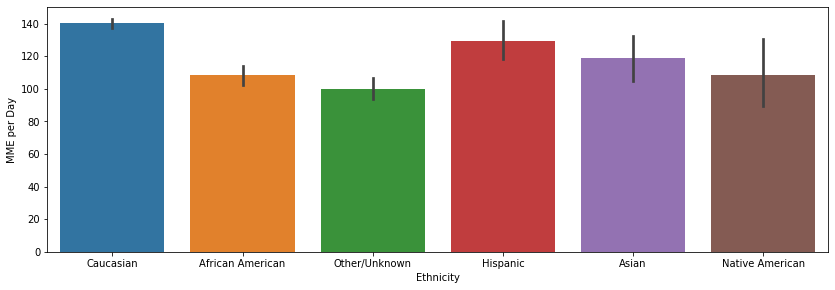

In [24]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='mme_per_day',data=opi_stat, estimator=np.mean)
plt.xlabel('Ethnicity')
plt.ylabel('MME per Day')

In [25]:
# Testing for Normal Distribution

opi_stat_c = list(opi_stat[opi_stat.ethnicity == 'Caucasian'].mme_per_day)
opi_stat_aa = list(opi_stat[opi_stat.ethnicity == 'African American'].mme_per_day)
opi_stat_a = list(opi_stat[opi_stat.ethnicity == 'Asian'].mme_per_day)
opi_stat_h = list(opi_stat[opi_stat.ethnicity == 'Hispanic'].mme_per_day)
opi_stat_na = list(opi_stat[opi_stat.ethnicity == 'Native American'].mme_per_day)
opi_stat_o = list(opi_stat[opi_stat.ethnicity == 'Other/Unknown'].mme_per_day)

k_c, p_c = stat.kstest(opi_stat_c, 'norm')
k_aa, p_aa = stat.kstest(opi_stat_aa, 'norm')
k_a, p_a = stat.kstest(opi_stat_a, 'norm')
k_h, p_h = stat.kstest(opi_stat_h, 'norm')
k_na, p_na = stat.kstest(opi_stat_na, 'norm')
k_o, p_o = stat.kstest(opi_stat_o, 'norm')

print('Caucasian: k-value:', k_c, 'p-value:', p_c)
print('African America: k-value:', k_aa, 'p-value:', p_aa)
print('Asian: k-value:', k_a, 'p-value:', p_a)
print('Hispanic: k-value:', k_h, 'p-value:', p_h)
print('Native American: k-value:', k_na, 'p-value:', p_na)
print('Other: k-value:', k_o, 'p-value:', p_o)

Caucasian: k-value: 0.8905860060408827 p-value: 0.0
African America: k-value: 0.8867535639335525 p-value: 0.0
Asian: k-value: 0.8714387715153448 p-value: 0.0
Hispanic: k-value: 0.9497111417179137 p-value: 0.0
Native American: k-value: 0.8794004056862293 p-value: 0.0
Other: k-value: 0.8843172024981202 p-value: 0.0


In [26]:
# Non-normal distributions, using non-parametric Kruskal-Wallis H-test

stat.kruskal(opi_stat_c,opi_stat_aa,opi_stat_a,opi_stat_h,opi_stat_na,opi_stat_o)

KruskalResult(statistic=299.5017324285344, pvalue=1.2816983291805704e-62)

In [27]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Multiple pairwise comparison (Tukey HSD) - whats the nonparametric equivalent?

m_comp = pairwise_tukeyhsd(endog=opi_stat['mme_per_day'], groups=opi_stat['ethnicity'], alpha=0.05)
m_comp.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
African American,Asian,10.3379,0.9,-18.652,39.3279,False
African American,Caucasian,31.8919,0.001,20.8693,42.9146,True
African American,Hispanic,21.2602,0.0514,-0.0719,42.5923,False
African American,Native American,0.0946,0.9,-34.4682,34.6575,False
African American,Other/Unknown,-8.4423,0.6992,-25.6025,8.718,False
Asian,Caucasian,21.554,0.217,-5.8005,48.9085,False
Asian,Hispanic,10.9222,0.9,-21.9689,43.8134,False
Asian,Native American,-10.2433,0.9,-52.9207,32.4341,False
Asian,Other/Unknown,-18.7802,0.49,-49.1322,11.5718,False
Caucasian,Hispanic,-10.6318,0.5904,-29.682,8.4185,False


In [28]:
nemenyi = sp.posthoc_nemenyi(opi_stat, 'mme_per_day', 'ethnicity')
nemenyi

,African American,Asian,Caucasian,Hispanic,Native American,Other/Unknown
African American,1.000000e+00,0.000038,1.638197e-43,9.985692e-01,0.056489,2.269785e-01
Asian,3.775858e-05,1.000000,9.999530e-01,2.086539e-03,0.972267,2.664726e-02
Caucasian,1.638197e-43,0.999953,1.000000e+00,5.992719e-12,0.853678,1.059800e-12
Hispanic,9.985692e-01,0.002087,5.992719e-12,1.000000e+00,0.195178,8.159907e-01
Native American,5.648862e-02,0.972267,8.536783e-01,1.951781e-01,1.000000,6.010804e-01
Other/Unknown,2.269785e-01,0.026647,1.059800e-12,8.159907e-01,0.601080,1.000000e+00


In [29]:
# Bonferroni correction

pvals = [] # grab pvals from nemenyi df above by columns

for i in nemenyi.columns:
    pvals = pvals + list(nemenyi[i])

from statsmodels.stats.multitest import multipletests

p_adjusted = multipletests(pvals, alpha=0.05, method='bonferroni')

In [30]:
print('Corrected alpha for Bonferroni method: ', p_adjusted[3])

Corrected alpha for Bonferroni method:  0.001388888888888889


In [31]:
group1 = []
group2 = []

for col in nemenyi.columns:
    for row in nemenyi.index:
        group1.append(col)
        group2.append(row)

In [32]:
d = {'group1': group1, 'group2': group2, 'p_vals': p_adjusted[1], 'reject': p_adjusted[0]}

nemenyi_comp = pd.DataFrame(data=d)

In [33]:
nemenyi_comp

,group1,group2,p_vals,reject
0,African American,African American,1.000000e+00,False
1,African American,Asian,1.359309e-03,True
2,African American,Caucasian,5.897510e-42,True
3,African American,Hispanic,1.000000e+00,False
4,African American,Native American,1.000000e+00,False
5,African American,Other/Unknown,1.000000e+00,False
6,Asian,African American,1.359309e-03,True
7,Asian,Asian,1.000000e+00,False
8,Asian,Caucasian,1.000000e+00,False
9,Asian,Hispanic,7.511540e-02,False


In [ ]:
# Still need to remove duplicates 
# (i.e., group1 = African American, group2 = Caucasian &  group1 = Caucasian, group2 = African American)

### Chi Square for Specific Groups

In [ ]:
opi_eth = pd.get_dummies(pts, columns=['ethnicity'])

In [ ]:
opi_eth.head()

In [ ]:
african_american = pd.crosstab(opi_eth.opioid, opi_eth['ethnicity_African American'])
african_american

In [ ]:
c, p, dof, expected = stat.chi2_contingency(african_american)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
asian = pd.crosstab(opi_eth.opioid, opi_eth['ethnicity_Asian'])
asian

In [ ]:
c, p, dof, expected = stat.chi2_contingency(asian)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
caucasian = pd.crosstab(opi_eth.opioid, opi_eth['ethnicity_Caucasian'])
caucasian

In [ ]:
c, p, dof, expected = stat.chi2_contingency(caucasian)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
hispanic = pd.crosstab(opi_eth.opioid, opi_eth['ethnicity_Hispanic'])
hispanic

In [ ]:
c, p, dof, expected = stat.chi2_contingency(hispanic)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
namerican = pd.crosstab(opi_eth.opioid, opi_eth['ethnicity_Native American'])
namerican

In [ ]:
c, p, dof, expected = stat.chi2_contingency(namerican)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
other = pd.crosstab(opi_eth.opioid, opi_eth['ethnicity_Other/Unknown'])
other

In [ ]:
c, p, dof, expected = stat.chi2_contingency(other)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

___
### Feature Engineering

In [ ]:
#apache score

apache = pd.read_csv('eicu-collaborative-research-database-2.0/apachePatientResult.csv.gz')

apache = apache[apache['apacheversion']=='IV']
apache_scores = apache[['patientunitstayid','apachescore','actualventdays']]
pts = pd.merge(pts, apache_scores, on=['patientunitstayid'], how = 'right')

In [ ]:
pts.actualventdays.fillna(value=0, inplace=True)

In [ ]:
# gcs score

gcs = pd.read_csv('eicu-collaborative-research-database-2.0/apachePredVar.csv.gz')

gcs = gcs[['patientunitstayid','verbal', 'motor', 'eyes']]
gcs['gcs_score'] = gcs['verbal'] + gcs['motor'] + gcs['eyes']
gcs = gcs[['patientunitstayid', 'gcs_score']]

pts = pd.merge(pts, gcs, on=['patientunitstayid'], how = 'right')

In [ ]:
pts['from_OR'] = pts['unitadmitsource'] == 'Operating Room'

In [ ]:
# admission HR

systolic = pd.read_csv('eicu-collaborative-research-database-2.0/vitalPeriodic.csv.gz')
systolic = systolic[['patientunitstayid', 'observationoffset', 'heartrate']]
systolic.to_csv('heartrate.csv')

In [ ]:
grouped_systolic = systolic.groupby('patientunitstayid').apply(lambda x: x.sort_values('observationoffset'))

first_values = grouped_systolic.drop_duplicates(subset='patientunitstayid', keep='first')
first_values['hr_over100'] = first_values['heartrate'] >= 100
first_values = first_values[['heartrate', 'hr_over100']]

first_values.to_csv('heartrate2.csv')

In [ ]:
first_values = pd.read_csv('heartrate2.csv')
pts = pd.merge(pts, first_values, on=['patientunitstayid'], how = 'right')

In [ ]:
pts['ICU_duration'] = (pts['unitdischargeoffset'] - pts['hospitaladmitoffset'])/1440

In [ ]:
# ordered protocols

cpg = pd.read_csv('eicu-collaborative-research-database-2.0/carePlanGeneral.csv.gz')

cpg = cpg[cpg.cplgroup == 'Ordered Protocols']
cpg.drop(columns=['cplgeneralid', 'activeupondischarge', 'cplitemoffset', 'cplgroup'], inplace = True)
cpg.drop_duplicates(inplace=True)

cpg = cpg.groupby('patientunitstayid')['cplitemvalue'].apply(list).reset_index(name='orderedprotocols')
cpg.head()

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
# one hot ecoding from list
mlb = MultiLabelBinarizer()
cpg = cpg.join(pd.DataFrame(mlb.fit_transform(cpg.pop('orderedprotocols')), columns=mlb.classes_, index=cpg.index))

In [ ]:
cpg.head()

In [ ]:
pts.head()

In [ ]:
pts = pts[(pts.admissionheight > 100)]
pts = pts[(pts.admissionweight > 0) & (pts.admissionweight < 200)]

In [ ]:
#pts.dropna(subset=['admissionheight','admissionweight'], inplace=True)
pts.drop(columns=['Unnamed: 1'], inplace=True)

In [ ]:
pts['admissionheight'] = pts['admissionheight'].replace(0, pts['admissionheight'].median())
pts['admissionweight'] = pts['admissionweight'].replace(0, pts['admissionweight'].median())
pts['age'] = pts['age'].replace(0, pts['age'].median())

In [ ]:
pts['BMI'] = (pts.admissionweight/pts.admissionheight/pts.admissionheight)*10000

In [ ]:
pts.head()

In [ ]:
# pain scores
pain = pd.read_csv('pain.csv')
pts = pd.merge(pts, pain, on=['patientunitstayid'], how = 'inner')

In [ ]:
pts.info()

In [ ]:
pts_final = pts[['patientunitstayid',
                 'gender', 
                 'age', 
                 'ethnicity',
                 'BMI', 
                 'actualventdays',
                 'ICU_duration',
                 'gcs_score', 
                 'apachescore', 
                 'from_OR',
                 'heartrate',
                 'teachingstatus',
                 'numbedscategory',
                 'opioid', 
                 'nsaid',
                 'painmeds',
                 'initialPain',
                 'finalPain']]

In [ ]:
pts_final.head()

In [ ]:
pts_final.to_csv('final_patients.csv')

In [ ]:
pts_final = pd.merge(pts_final, opi_stat, on=['patientunitstayid'], how = 'left')
pts_final.head()

In [ ]:
pts_final.mme_per_day.fillna(0.0,inplace=True)

In [ ]:
pts_final.dropna(inplace=True)

In [ ]:
pts_final["painmeds"] = pts_final["painmeds"].astype(int)
pts_final["opioid"] = pts_final["opioid"].astype(int)
pts_final["nsaid"] = pts_final["nsaid"].astype(int)
pts_final["from_OR"] = pts_final["from_OR"].astype(int)
#pts_final["hr_over100"] = pts_final["hr_over100"].astype(int)

In [ ]:
pts_final.teachingstatus.replace('t', 1, inplace=True)
pts_final.teachingstatus.replace('f', 0, inplace=True)

pts_final.gender.replace('Male', 1, inplace=True)
pts_final.gender.replace('Female', 0, inplace=True)

In [ ]:
pts_final.head()

In [ ]:
pts_final.to_csv('pts_no_dummies.csv')

In [ ]:
pts_final = pd.read_csv('pts_no_dummies.csv')

In [ ]:
pts_final = pd.get_dummies(pts_final, columns = ['numbedscategory'], drop_first = False)
pts_final = pd.get_dummies(pts_final, columns = ['ethnicity'], drop_first = False)

In [ ]:
pts_final = pd.merge(pts_final, cpg, on=['patientunitstayid'])

In [ ]:
pts_final.head()

In [ ]:
pts_final.to_csv('pts_dummies.csv')

In [ ]:
pts_final.info()

In [ ]:
pts_drop = pts_final.dropna()

In [ ]:
pts_drop.info()

In [ ]:
pts_drop.head()

In [ ]:
pts_drop.to_csv('pts_dummies.csv')

___
### Multivariate Analysis

In [ ]:
def logreg_df(df, norm_cols, drop_cols, y_col, drop=False, reg=0):
    """
    df (string): CSV path.
    cat_cols (list): categorical columns to one-hot-encode.
    norm_cols (list): columns in df to normalize.
    drop_cols (list): columns to drop.
    y_col (string): variable of interest.
    """
    
    #df = pd.read_csv('df')
    #df = pd.get_dummies(df, columns = cat_cols, drop_first = drop)
    
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.model_selection import train_test_split
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.datasets import load_iris
    
    df[norm_cols] = MinMaxScaler().fit_transform(df[norm_cols])
    
    if reg == 0:
        X = df.drop(columns = drop_cols)
        y = df[y_col]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
        
        log = LogisticRegression(penalty='l1',solver='liblinear')
        res = log.fit(X, y)
        
        #print(res)
        #print(res.coef_, res.intercept_)
        
        logit_model = sm.Logit(y, X)
        result = logit_model.fit(maxiter=1)

        print(result.summary2())
        
        params = result.params
        conf = result.conf_int()
        conf['Odds Ratio'] = params
        conf.columns = ['5%', '95%', 'Odds Ratio']
        print(np.exp(conf))
        print('==========================')
        
    elif reg == 1:
        X = df.drop(columns = drop_cols)
        y = df[y_col]
        X = sm.add_constant(X)
        
        ols_model = sm.OLS(y,X)
        result = ols_model.fit()
        
        print(result.summary())
        
        y_pred = result.predict(X)
    
    return result, y_pred, y, X

#### Painmeds by Ethnicity

In [ ]:
eth = ['ethnicity_Caucasian', 'ethnicity_African American', 'ethnicity_Asian',
      'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown']

for i in eth:
    norm = ['actualventdays','age', 'gcs_score', 'apachescore']
    dp = ['opioid', 'nsaid', 'patientunitstayid','painmeds','mme_per_day',i]
    
    print("Compared to ", i)
    logreg_df(pts_final, norm, dp, 'painmeds')

In [ ]:
# In the above Caucasian baseline, there was no significance with African Americans, so why is it not both ways?

In [ ]:
# basically the above is saying compared to caucasians, hispanic and native american are signiciant 
# - both are more likely to receive pain meds

#### Ethnicity vs. Receiving Opioids

In [ ]:
eth = ['ethnicity_Caucasian', 'ethnicity_African American', 'ethnicity_Asian',
      'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown']

for i in eth:
    norm = ['actualventdays','age','gcs_score', 'apachescore']
    dp = ['patientunitstayid','painmeds','opioid', i]
    
    print("Compared to ", i)
    logreg_df(pts_final, norm, dp, 'opioid', reg=0)

#### Ethnicity vs. MME

In [ ]:
eth = ['ethnicity_Caucasian', 'ethnicity_African American', 'ethnicity_Asian',
      'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown']

models = []

for i in eth:
    norm = ['actualventdays','age', 'gcs_score', 'apachescore']
    dp = ['mme_per_day','patientunitstayid','painmeds','opioid', i]
    
    print("Compared to ", i)
    ols, y_pred, y_true, X = logreg_df(pts_final, norm, dp, 'mme_per_day', reg=1)
    models.append((y_pred, y_true, X))

In [ ]:
plt.figure(figsize=(14, 4.5))
plt.plot(models[0][0], label="OLS", alpha=0.5)
plt.plot(models[0][1], label="True", alpha=0.5)
plt.legend(loc='best')
plt.xlabel('Patient Number')
plt.ylabel('MME per Day')

#### Figures

In [ ]:
pts_figs = pd.read_csv('pts_no_dummies.csv')
pts_figs.head()

In [ ]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='painmeds',data=pts_figs, estimator=np.mean)
plt.xlabel('Patient Ethnicity')
plt.ylabel('Proportion Receiving Pain Medications')

In [ ]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='nsaid',data=pts_figs, estimator=np.mean)
plt.xlabel('Patient Ethnicity')
plt.ylabel('Proportion Receiving NSAIDs')

In [ ]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='opioid',data=pts_figs, estimator=np.mean)
plt.xlabel('Patient Ethnicity')
plt.ylabel('Proportion Receiving Opioids')

In [ ]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='mme_per_day',data=pts_figs, estimator=np.mean)
plt.xlabel('Patient Ethnicity')
plt.ylabel('MME per Day')

___
### Other Models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error

X = pts_final.drop(columns = ['mme_per_day','patientunitstayid','painmeds','opioid'])
y = pts_final['mme_per_day']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)

In [ ]:
y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

In [ ]:
# fake patient with figure

In [ ]:
# https://towardsdatascience.com/multiple-imputation-with-random-forests-in-python-dec83c0ac55b